This is a model from https://www.kaggle.com/code/nakulsingh1289/face-expression-detection-from-scratch/notebook

modified to meet a more modern keras style and improved coding style

## Image augmentation using keras ImageDataGenerator

In [1]:
# building data generator 
from keras.preprocessing.image import ImageDataGenerator

base_path = "./images/"
batch_size = 128

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(56, 56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(56, 56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

2022-10-17 15:51:44.021343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 15:51:44.127752: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 15:51:44.511945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.1/targets/x86_64-linux/lib:/usr/local/cuda-11.7/targets/x86_64-linux/lib
2022-10-17 15:51:44.511985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining our 4 Convolution and 2 Dense layers model

In [2]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential([

    # 1 - Convolution
    Conv2D(64, (3, 3), padding='same', input_shape=(56, 56, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 2nd Convolution layer
    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 3rd Convolution layer
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 4th Convolution layer
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flattening
    Flatten(),

    # Fully connected layer 1st layer
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # Fully connected layer 2nd layer
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25)
])

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       2

2022-10-17 15:51:45.487747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 15:51:45.505848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 15:51:45.506005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 15:51:45.506424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# number of epochs to train the NN
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/50


2022-10-17 15:51:47.095659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


224/225 [============================>.] - ETA: 0s - loss: 2.0723 - accuracy: 0.2132
Epoch 1: val_accuracy improved from -inf to 0.17287, saving model to model_weights.h5
225/225 [==============================] - 13s 47ms/step - loss: 2.0719 - accuracy: 0.2132 - val_loss: 1.8723 - val_accuracy: 0.1729
Epoch 2/50
224/225 [============================>.] - ETA: 0s - loss: 1.9255 - accuracy: 0.2408
Epoch 2: val_accuracy improved from 0.17287 to 0.17315, saving model to model_weights.h5
225/225 [==============================] - 10s 46ms/step - loss: 1.9249 - accuracy: 0.2413 - val_loss: 1.8940 - val_accuracy: 0.1732
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.8736 - accuracy: 0.2577
Epoch 3: val_accuracy improved from 0.17315 to 0.29091, saving model to model_weights.h5
225/225 [==============================] - 11s 48ms/step - loss: 1.8736 - accuracy: 0.2577 - val_loss: 1.7717 - val_accuracy: 0.2909
Epoch 4/50
225/225 [==============================] - ETA: 0

In [4]:
from matplotlib import pyplot as plt

# visualise training and testing accuracy and loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# print best epoch with best accuracy on validation
def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc = max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))

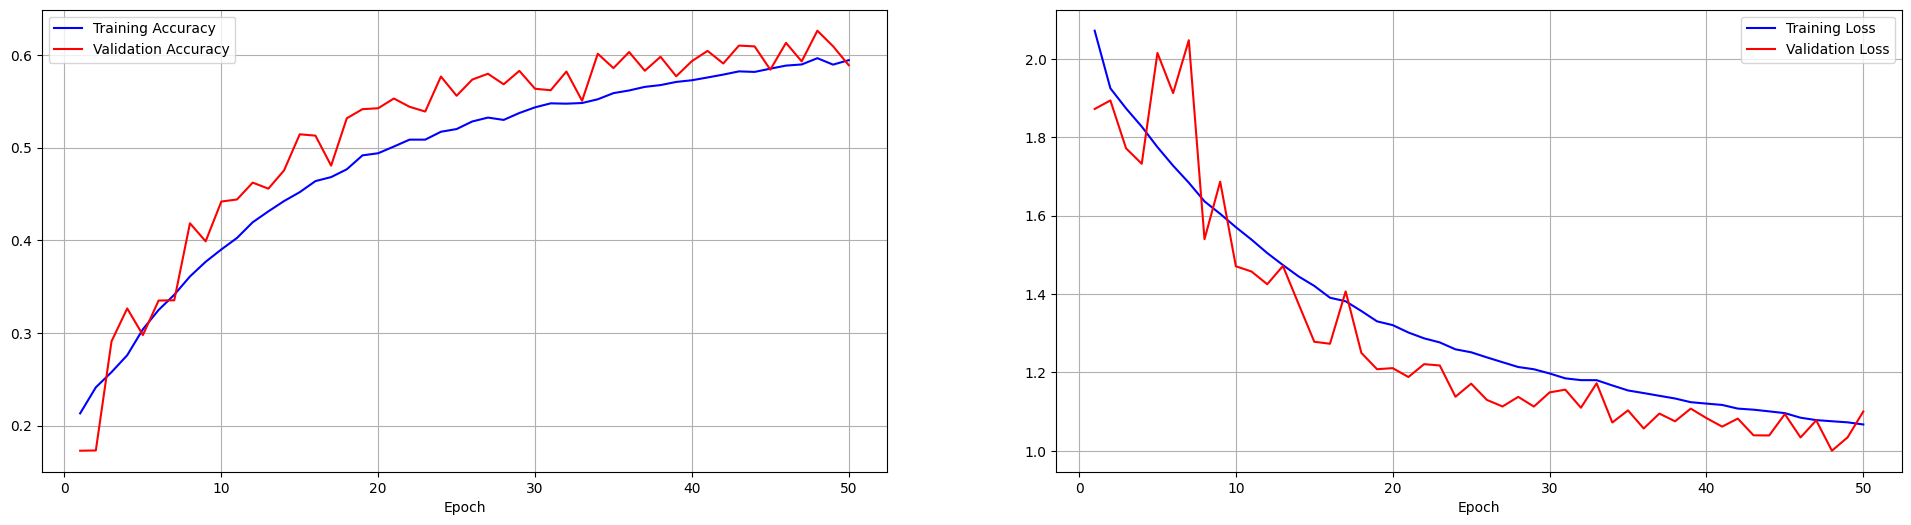

Best Validation Accuracy Score 0.62614, is for epoch 48


In [5]:
plot_results(history)
get_best_epoch(history)